In this notebook, we will learn the basic Class Activation Map method, which is an interpretability method for identifying which parts of an image have the most impact on a classifier's prediction.

### Imports

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

### Building Our Visualization Model

From the VGG16_Transfer_Learning notebook, we first load the VGG16_modified  network, which has been adjusted to the cats_vs_dog dataset. Then, we will create a visualization model to figure out how the CAM method works. The visualization model outputs:

1. Intermediate activation maps (Conv2D outputs) of the VGG16_modified. I have chosen the last Conv2D layer.

2. Label predicted by VGG16_modified

In [ ]:
base_model = tf.keras.models.load_model("VGG16_transfer_learning.h5", compile=False)
base_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,0

 Total params: 14,717,762 (56.14 MB)

 Trainable params: 7,081,474 (27.01 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

In [ ]:
cam_model  = Model([base_model.input],
                   [base_model.layers[-5].output, base_model.output])

In [ ]:
print(base_model.layers[-5].name)

block5_conv3


In [ ]:
layer_weights = cam_model.layers[-1].get_weights()[0]
layer_bias = cam_model.layers[-1].get_weights()[1]

print(f"Layer weights shape {layer_weights.shape}")
print(f"Layer bias shape {layer_bias.shape}")

Layer weights shape (512, 2)
Layer bias shape (2,)


### Reload Test Images

Loading some test images to see the CAM method's output.

In [ ]:
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

# load the dataset given the splits defined above
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.RYP8FT_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
labels= {
    0: "CAT",
    1: "DOG"
}

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

test_batches = test_examples.map(format_image).batch(1)

### Implementing Class Activation Map (CAM)

In the CAM method, we assign weights to each filter of the output of a selected convolutional layer, which is also called activation map.

$$M_c(x, y) = \Sigma_k \; w_k^c \; f_k(x,y) $$

In the above formula, $w_k^c$ is the weight assigned to the $k$ th filter. But how are these weights obtained?

Based on the [original paper](https://arxiv.org/pdf/1512.04150) , the weights of the last pooling layer (before Dense) are multiplied into the activation maps. Note that the length of the weights' vector is equal to the number of filters in the activation map. In our example, $w_k^c$ is $(512, 1)$, and the activation map is $(14, 14, 512)$. So when these two are dotted, a 2D image is acheived.

In [ ]:
def show_cam(image, features, weights, pred_label):
  '''
  Displays the class activation map of an image
  '''
  # The two following tensors have (1, h, w, c) shape, so we remove the first dimension.
  image = image[0]
  features_for_img = features[0]
  class_activation_weights = weights[:, 0]
  # print("Weights shape: ", class_activation_weights.shape)
  if pred_label == 'DOG':
    class_activation_weights = -class_activation_weights

  print("Features for image shape: ", features_for_img.shape)
  print("Class activation weights: ", class_activation_weights.shape)

  # upsample to the image size
  # Why 37 in 300/37? Because the last layer before average_pooling has (37, 37, 128) shape.
  # Why is the last layer Dense(1)? Because there are only two classes (CAT AND DOG).
  class_activation_features = sp.ndimage.zoom(features_for_img, (image.shape[0]/features_for_img.shape[0], \
                                                                 image.shape[1]/features_for_img.shape[1], 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features, class_activation_weights)
  cam_output = np.maximum(cam_output, 0)
  cam_output = cam_output / cam_output.max()

  plt.figure(figsize=(8,8))
  cam_intensity = plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.axis("off")
  plt.colorbar(cam_intensity)
  plt.imshow(image, alpha=0.5)
  plt.title(f"Class Activation Map for class {pred_label}")
  plt.axis("off")
  plt.show()


### Visualize Results

As the outputs indicate, for cats, the filters (features) related to eyes are the most decisive. For dogs, nose and pawls are the parts which our VGG16_modified network pays attention to when putting label.

In [ ]:
def convert_and_classify(image):

  features, results = cam_model.predict(image)

  # generate the CAM

  if results[0][0][0] >= results[0][0][1]:
    pred_label = 'CAT'
  else:
    pred_label = 'DOG'
  show_cam(image, features, layer_weights, pred_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Features for image shape:  (14, 14, 512)
Class activation weights:  (512,)


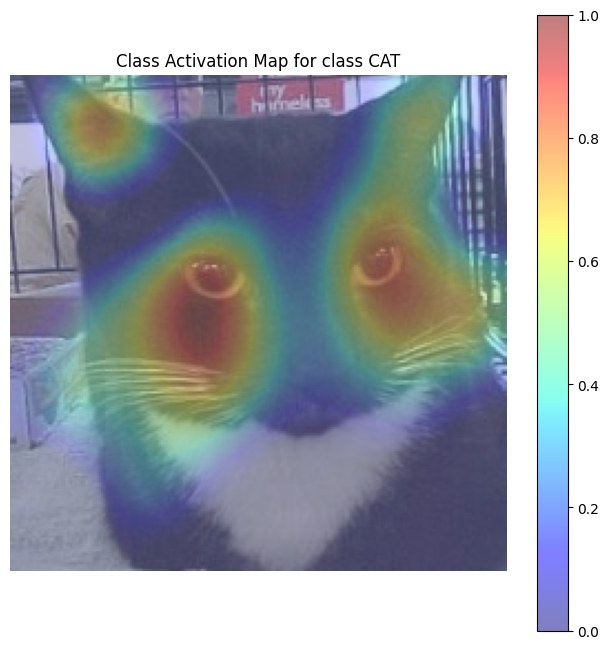

In [ ]:
sample_index = 15

for img, label in test_batches.take(sample_index):
    sample_image = img

convert_and_classify(sample_image)

In [ ]:
sample_index = 12

for img, label in test_batches.take(sample_index):
    convert_and_classify(img)


Output hidden; open in https://colab.research.google.com to view.